In [ ]:
import os
import glob
import sklearn
import pandas as pd
import numpy as np
import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import metrics 
drive.mount("/content/drive")
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
#function to read geotiff
def readtiff(filename):
    # @ file name to read
    file = gdal.Open(filename, gdal.GA_ReadOnly)
    band_number = file.RasterCount
    #print(band_number)
    #data = file.GetRasterBand(0,23)
    #print(data)
    array = file.ReadAsArray()
    return array

In [ ]:
#read RS data
RS_file = '/content/drive/MyDrive/Senior Design/Competition /Dataset/new/Iran_NDVI.tif'
array_NDVI = readtiff(RS_file)
array_shape = array_NDVI.shape
array_result = np.zeros((array_shape[1],array_shape[2]),dtype=int)
file_geo = gdal.Open(RS_file, gdal.GA_ReadOnly)

In [ ]:
#read samples
train_file_noncrop = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_inten_iran_noncropland.csv",index_col=False)
train_file_noncrop=train_file_noncrop.sample(n=350)

train_file_noncrop_water = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_intensity_iran_water.csv",index_col=False)
train_file_noncrop_water =train_file_noncrop_water.sample(n=100) #10% of noncropland
train_file_noncropland = pd.concat([train_file_noncrop_water,train_file_noncrop])

train_file_crop= pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_inten_cropland.csv", index_col=False)


df_SR= pd.concat([train_file_noncropland,train_file_crop])
df_SR= df_SR.drop(["system:index",".geo","landclass"], axis = 1);

df_SR= df_SR.fillna(0)

In [ ]:
from scipy.signal import savgol_filter
def ndvi_reconstruct(df):
  for i in range(len(df)):
    for j in range(len(df.columns)-1):
       if df.iat[i,j] == 0 or  abs(df.iat[i,j-1] - df.iat[i,j]) > 4000 :
              df.iat[i,j] = ((df.iloc[i][1]+df.iloc[i][len(df.columns)-1])/2.0)
       if j == len(df.columns)-1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][0])/2.0)
       if j != 0 and j != len(df.columns) - 1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][j+1])/2.0)
  return df

In [ ]:
df_SR = ndvi_reconstruct(df_SR)

In [ ]:
from scipy.signal import savgol_filter
smoothed_NDVI = savgol_filter(df_SR, window_length = 3, polyorder = 2)
series1 = smoothed_NDVI.astype(float)

def find_cycles(Y):   
  row=Y
  l=0
  max=row[0]
  for l in range(24):
    if(row[l]>max):
      max=row[l]
    l=l+1
  if(max<3000):
    return 0

  max_val=0.7*max
  min_val=0.2*max
  maxima = []
  i =0
  while i<row.size:
    if(i==0):
      if(row[i]>=max_val):
        j=i+1;
        while(j!=24): #right traversal
          
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=j
            break
          elif(j==23):
            j=j+1
            i=i+1
          else:
            j=j+1
      else:
          i=i+1

    elif(i==23):
      if(row[i]>=max_val):
        j=i-1;
        while(j!=-1): #left traversal 
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=i+1
            break
          elif(j==0):
            j=j-1
            i=i+1
          else:
            j=j-1;
      else:
        i=i+1

    elif(i!=24):
      check=False
      # proceed=False
      if(row[i]>=max_val):
        j=i+1
        k=i-1
        while(j!=24): #right traversal
          if(row[j]<=min_val):
            # maxima.append(i)
            check=True
            break
          elif(row[j]>=max_val):
            # proceed=True
            i=j
            k=i-1
            j=j+1
            # break
          else:
            j=j+1;
        while(k!=-1): #left traversal
          if(row[k]<=min_val):
            # maxima.append(i)
            if(check==True):
              maxima.append(i)
              i=i+1
              break
            else:
              i=i+1
              break
          elif(row[k]>=max_val):
            if(k==0):
              i=i+1
            k=k-1
            # i=i+1
            # break
          elif k==0:
            i=i+1
            k=k-1
          else:
            k=k-1;
      else:
        i=i+1
    else:
      i=i+1
  return len(maxima)

In [ ]:
df_filter = pd.DataFrame(series1, columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

In [ ]:
df_filter.insert(24,"cycles"," ")

In [ ]:
for i in range(len(df_filter)):
  
  df_filter.cycles.iloc[i] = find_cycles(df_filter.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
class_0 = df_filter[df_filter['cycles']==0]
print(len(class_0.index))
class_1 = df_filter[df_filter['cycles']==1]
print(len(class_1.index))
class_2 = df_filter[df_filter['cycles']==2]
print(len(class_2.index))
class_3 = df_filter[df_filter['cycles']==3]
print(len(class_3.index))

2778
1692
57
0


0     2692.000000
1     2623.000000
2     2544.000000
3     2605.500000
4     2646.750000
5     2529.375000
6     1607.687500
7     2209.843750
8     2495.421875
9     1247.710938
10    2020.855469
11    2675.427734
12    3318.713867
13    3646.356934
14    1823.178467
15    3717.589233
16    4821.294617
17    4914.147308
18    3870.573654
19    2984.786827
20    2745.393414
21    2788.196707
22    2848.598353
23    2909.000000
Name: 63, dtype: float64


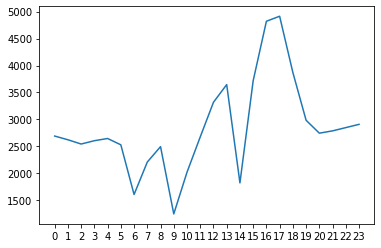

In [ ]:
class_0_plot = class_0.drop(['cycles'], axis=1)
plt.plot(class_0_plot.iloc[32])
plt.plot()
print(class_0_plot.iloc[32])

In [ ]:
class_0=class_0.sample(n=58)
class_1=class_1.sample(n=58)
class_2=class_2.sample(n=58) 

ValueError: ignored

In [ ]:
dataset = pd.concat([class_0,class_1,class_2,class_3])

In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=x_train.astype('int')
y_train=y_train.astype('int')
x_test=x_test.astype('int')
y_test=y_test.astype('int')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(oob_score=True, criterion='entropy',verbose=3)   
rf_clf.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
y_pred = rf_clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

In [ ]:
import ee

In [ ]:
!pip install -U geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geemap
from geemap import ml
from sklearn import ensemble

In [ ]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=28oIqTMn6IxPefNvySDlhML2aTWDoPQZgJeN2k88B78&tc=VWpChr_X5nINg3VnWNBDQQpyKq5ZnCTE0ESuDX892tg&cc=iRh0feFEbf9Vv-C2kYRB1AwXUstqBjVqZKLKqkICLok

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJq5wtkLQIiIg5l3XmUGxVJxus12DNIbLt28KS4q8CZpdAmR522dvB4

Successfully saved authorization token.


In [ ]:
feature_names = ['nd_p100','nd_p100_1','nd_p100_2','nd_p100_3','nd_p100_4','nd_p100_5','nd_p100_6','nd_p100_7','nd_p100_8','nd_p100_9','nd_p100_10','nd_p100_11','nd_p100_12','nd_p100_13','nd_p100_14','nd_p100_15','nd_p100_16','nd_p100_17','nd_p100_18','nd_p100_19','nd_p100_20','nd_p100_21','nd_p100_22','nd_p100_23']
label = "cycles"

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf_clf, feature_names)

In [ ]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
l8 = ee.Image('projects/ee-g00085636/assets/NDVI_IRAN_unmasked') #the unmasked image from google earth engine (I converted it into a google earth engine asset first)

In [ ]:
# classify the image using the classifier we created from the local training
# note: here we select the feature_names from the image that way the classifier knows which bands to use
classified = l8.select(feature_names).classify(ee_classifier)

In [ ]:
# display results
Map = geemap.Map(center=(32.4279, 53.6880),zoom=11)

Map.addLayer(
    l8,
    {"bands": ['nd_p100_2','nd_p100_5','nd_p100_7'], "min": -10000, "max": 10000, "gamma": 1.5},
    'image',
)
Map.addLayer(
    classified,
    { "palette": ['red', 'green', 'blue']},
    'classification',
)
Map

Map(center=[32.4279, 53.688], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(objective='multi:softmax', early_stopping_rounds=10)
xgb_cl.fit(x_train,y_train,
           verbose=True)

y_pred = xgb_cl.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[19  0  0]
 [ 4 11  1]
 [ 0  1 22]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.92      0.69      0.79        16
           2       0.96      0.96      0.96        23

    accuracy                           0.90        58
   macro avg       0.90      0.88      0.88        58
weighted avg       0.90      0.90      0.89        58

0.896551724137931
Weighted f1_score=  0.8924466338259441
Weighted precision =  0.9027986006996502


In [ ]:
!pip install dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=e4059cc7829156777446cf12504314a3246ff8a331036ad4f0e6d9caf4739a68
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw


In [ ]:
import dtw

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance

In [ ]:
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
parameters = {'n_neighbors':[1]}
clf = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)
clf.fit(x_train, y_train)



#evaluate
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        19
           1       0.75      0.75      0.75        16
           2       0.96      1.00      0.98        23

    accuracy                           0.86        58
   macro avg       0.85      0.85      0.85        58
weighted avg       0.86      0.86      0.86        58



In [ ]:
#read samples
train_file_noncrop = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_inten_iran_noncropland.csv",index_col=False)
train_file_noncrop=train_file_noncrop.sample(n=350)

train_file_noncrop_water = pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_intensity_iran_water.csv",index_col=False)
train_file_noncrop_water =train_file_noncrop_water.sample(n=100) #10% of noncropland
train_file_noncropland = pd.concat([train_file_noncrop_water,train_file_noncrop])

train_file_crop= pd.read_csv("/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/samples_inten_cropland.csv", index_col=False)


df_SR= pd.concat([train_file_noncropland,train_file_crop])

df_SR= df_SR.fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
x=df_SR.drop(["system:index",".geo","landclass"], axis = 1);
y=df_SR["landclass"]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=np.array(x_train).astype('float')
y_train=np.array(y_train).astype('float')
x_test=np.array(x_test).astype('float')
y_test=np.array(y_test).astype('float')


In [ ]:
x_train_lstm = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test_lstm = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
from keras.metrics.metrics import accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

n_steps = 24
n_features = 1 
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'],)

In [ ]:
from sklearn import preprocessing
def normalize(df):
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  names = df.columns
  d = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(d, columns=names)
  return scaled_df

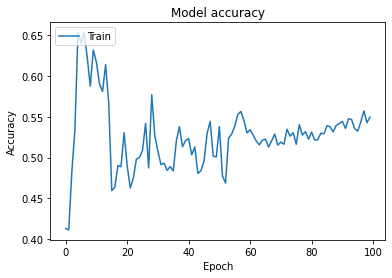

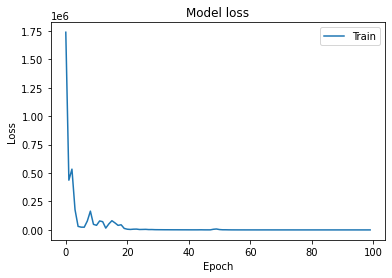

In [ ]:
plt.plot(hist.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# expected_y  = y_test
# predicted_y = model.predict(x_test_lstm, verbose=0)
scores = model.evaluate(x_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 65.13%


In [ ]:
from keras.layers import Bidirectional, Activation

model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True),
                             input_shape=(24, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mse',
optimizer='adam',
metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train_lstm, y_train, epochs = 100)

Epoch 1/100
95/95 [==============================] - 13s 45ms/step - loss: 0.0757 - accuracy: 0.9083
Epoch 2/100
95/95 [==============================] - 4s 45ms/step - loss: 0.0635 - accuracy: 0.9288
Epoch 3/100
95/95 [==============================] - 4s 45ms/step - loss: 0.0499 - accuracy: 0.9449
Epoch 4/100
95/95 [==============================] - 4s 46ms/step - loss: 0.0380 - accuracy: 0.9594
Epoch 5/100
95/95 [==============================] - 4s 45ms/step - loss: 0.0403 - accuracy: 0.9578
Epoch 6/100
95/95 [==============================] - 4s 44ms/step - loss: 0.0325 - accuracy: 0.9647
Epoch 7/100
95/95 [==============================] - 4s 47ms/step - loss: 0.0335 - accuracy: 0.9641
Epoch 8/100
95/95 [==============================] - 4s 46ms/step - loss: 0.0378 - accuracy: 0.9601
Epoch 9/100
95/95 [==============================] - 4s 45ms/step - loss: 0.0599 - accuracy: 0.9347
Epoch 10/100
95/95 [==============================] - 4s 46ms/step - loss: 0.0609 - accuracy: 0.933

In [ ]:
scores = model.evaluate(x_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.45%


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Defining custom metrics to record while running
from keras import backend as K

def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
for i in range(array_shape[1]):
  #get the data for a line
  temp_array = array_NDVI[:,i,:]
  temp_df = pd.DataFrame(temp_array.T)
  temp_df.columns = pd.DataFrame(x_train).columns.tolist() #unnormalized_x_train (CAUTIOS) 
  array_result[i,:] = rf_clf.predict(temp_df)

Streaming output truncated to the last 5000 lines.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs

In [ ]:
Output_file = '/content/drive/MyDrive/Senior Design/Competition /Dataset/Competition_Dataset/Output/Cropland_extent_Iran_intensity_smooth.tif' #change
driver = gdal.GetDriverByName('Gtiff')
outRaster = driver.Create(Output_file, file_geo.RasterXSize, file_geo.RasterYSize, 1, gdal.GDT_Byte)
outRaster.SetGeoTransform(file_geo.GetGeoTransform())
outRaster.SetProjection(file_geo.GetProjection())
outRaster.GetRasterBand(1).WriteArray(array_result)
outRaster = None